In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from netCDF4 import Dataset
import matplotlib as mpl

In [18]:
with Dataset("f09.F2000_MJO_1year.cam.h0.1year.nc", "r") as f:
    
    Q = f["FLNT"][:]      # shape (time, lat, lon)   
    lat = f["lat"][:]
    lon = f["lon"][:]
    time = f["time"][:]
    
lat_band=(-15, 15)
Q_eq = Q[:, lat_band,:].mean(axis=1)
from scipy.fft import fft, ifft, fftfreq
# Apply FFT along specified dimensions while keeping xarray metadata

q1_fft: np.ndarray = fft(Q_eq, axis=0); # fft on time
q1_fft: np.ndarray = ifft(q1_fft, axis=1) * lon.shape[0]; # fft on lon

# Apply bandpass filter on q1_fft
fr: np.ndarray = fftfreq(Q_eq.shape[0], d=1);
wn: np.ndarray = fftfreq(Q_eq.shape[1], d=1/lon.shape[0]).astype(int);

wnm, frm = np.meshgrid(wn, fr);

## define kelvin waves curve
# kel_curve = lambda wn, ed: wn * np.sqrt(9.81 * ed) * (86400 / (2*np.pi*6.371e6));

q1_sel: np.ndarray = np.where(
    ((wnm >= 1) & (wnm <=5) &
    (frm >= 1/60) & (frm <= 1/30)# &
    #(frm >= kel_curve(wnm, 8)) & (frm <= kel_curve(wnm, 90))
     ) |
    ((wnm <= -1) & (wnm >=-5) &
    (frm <= -1/60) & (frm >= -1/30) #&
    #(frm <= kel_curve(wnm, 8)) & (frm >= kel_curve(wnm, 90))
    ), 1, 0
        );

kel_sel = q1_fft * q1_sel[:, :];

# reconstruct q1
q1_recon = fft(kel_sel, axis=1) / lon.shape[0];
q1_recon = ifft(q1_recon, axis=0).real

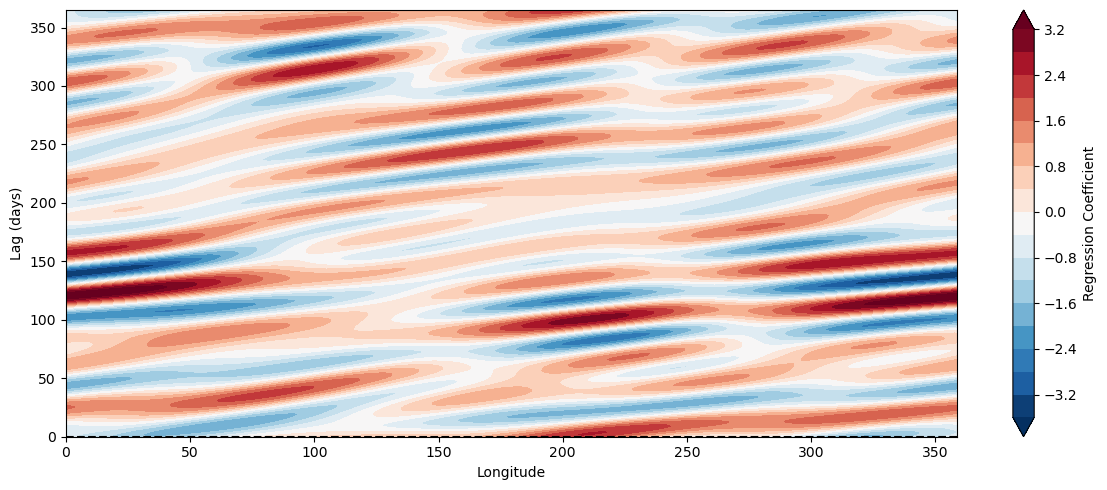

In [19]:
plt.figure(figsize=(12, 5))

# 計算對稱範圍，最大絕對值
# vabs = np.nanmax(np.abs(q1_recon))

# norm = TwoSlopeNorm(vmin=-vabs, vcenter=0, vmax=vabs)

cf = plt.contourf(
    lon, time, q1_recon,
    levels=21,
    cmap="RdBu_r",
    # norm=norm,
    extend="both"
)

plt.axhline(0, color='k', linestyle='--')
plt.xlabel("Longitude")
plt.ylabel("Lag (days)")
# plt.title(title)
plt.colorbar(cf, label="Regression Coefficient")
plt.tight_layout()
plt.show()

In [20]:
import numpy as np
from scipy.fft import fft, ifft, fftfreq

class MJOFilter:
    def __init__(self, wavenumber_range=(1, 5), period_range=(30, 90)):
        """
        Parameters:
        - wavenumber_range: tuple (min_k, max_k), zonal wavenumber range
        - period_range: tuple (min_period, max_period), in days
        """
        self.kmin, self.kmax = wavenumber_range
        self.pmin, self.pmax = period_range
        self.q_recon = None
        self.lon = None
        self.time = None

    def fit_transform(self, Q, lat, lon, lat_range=(-15, 15)):
        """
        Apply MJO band-pass filtering on Q(time, lat, lon)

        Returns:
        - q_recon: filtered Q_eq(time, lon) with only MJO signals
        """
        lat_mask = (lat >= lat_range[0]) & (lat <= lat_range[1])
        Q_eq = Q[:, lat_mask, :].mean(axis=1)  # (time, lon)

        ntime, nlon = Q_eq.shape
        self.lon = lon
        self.time = np.arange(ntime)

        # FFT (time axis)
        q_fft_time = fft(Q_eq, axis=0)  # (time_f, lon)
        q_fft_wavenum = ifft(q_fft_time, axis=1) * nlon  # (time_f, wavenum)

        # Build freq-wavenumber grid
        freq = fftfreq(ntime, d=1)  # cycles/day
        wn = fftfreq(nlon, d=1/nlon).astype(int)
        wnm, frm = np.meshgrid(wn, freq)

        # MJO mask: eastward wavenumber and ~30–90 day period
        mjo_mask = (
            (wnm >= self.kmin) & (wnm <= self.kmax) &
            (frm >= 1 / self.pmax) & (frm <= 1 / self.pmin)
        )

        q_fft_masked = q_fft_wavenum * mjo_mask
        q_ifft_k = fft(q_fft_masked, axis=1) / nlon
        self.q_recon = ifft(q_ifft_k, axis=0).real  # back to (time, lon)

        return self.q_recon


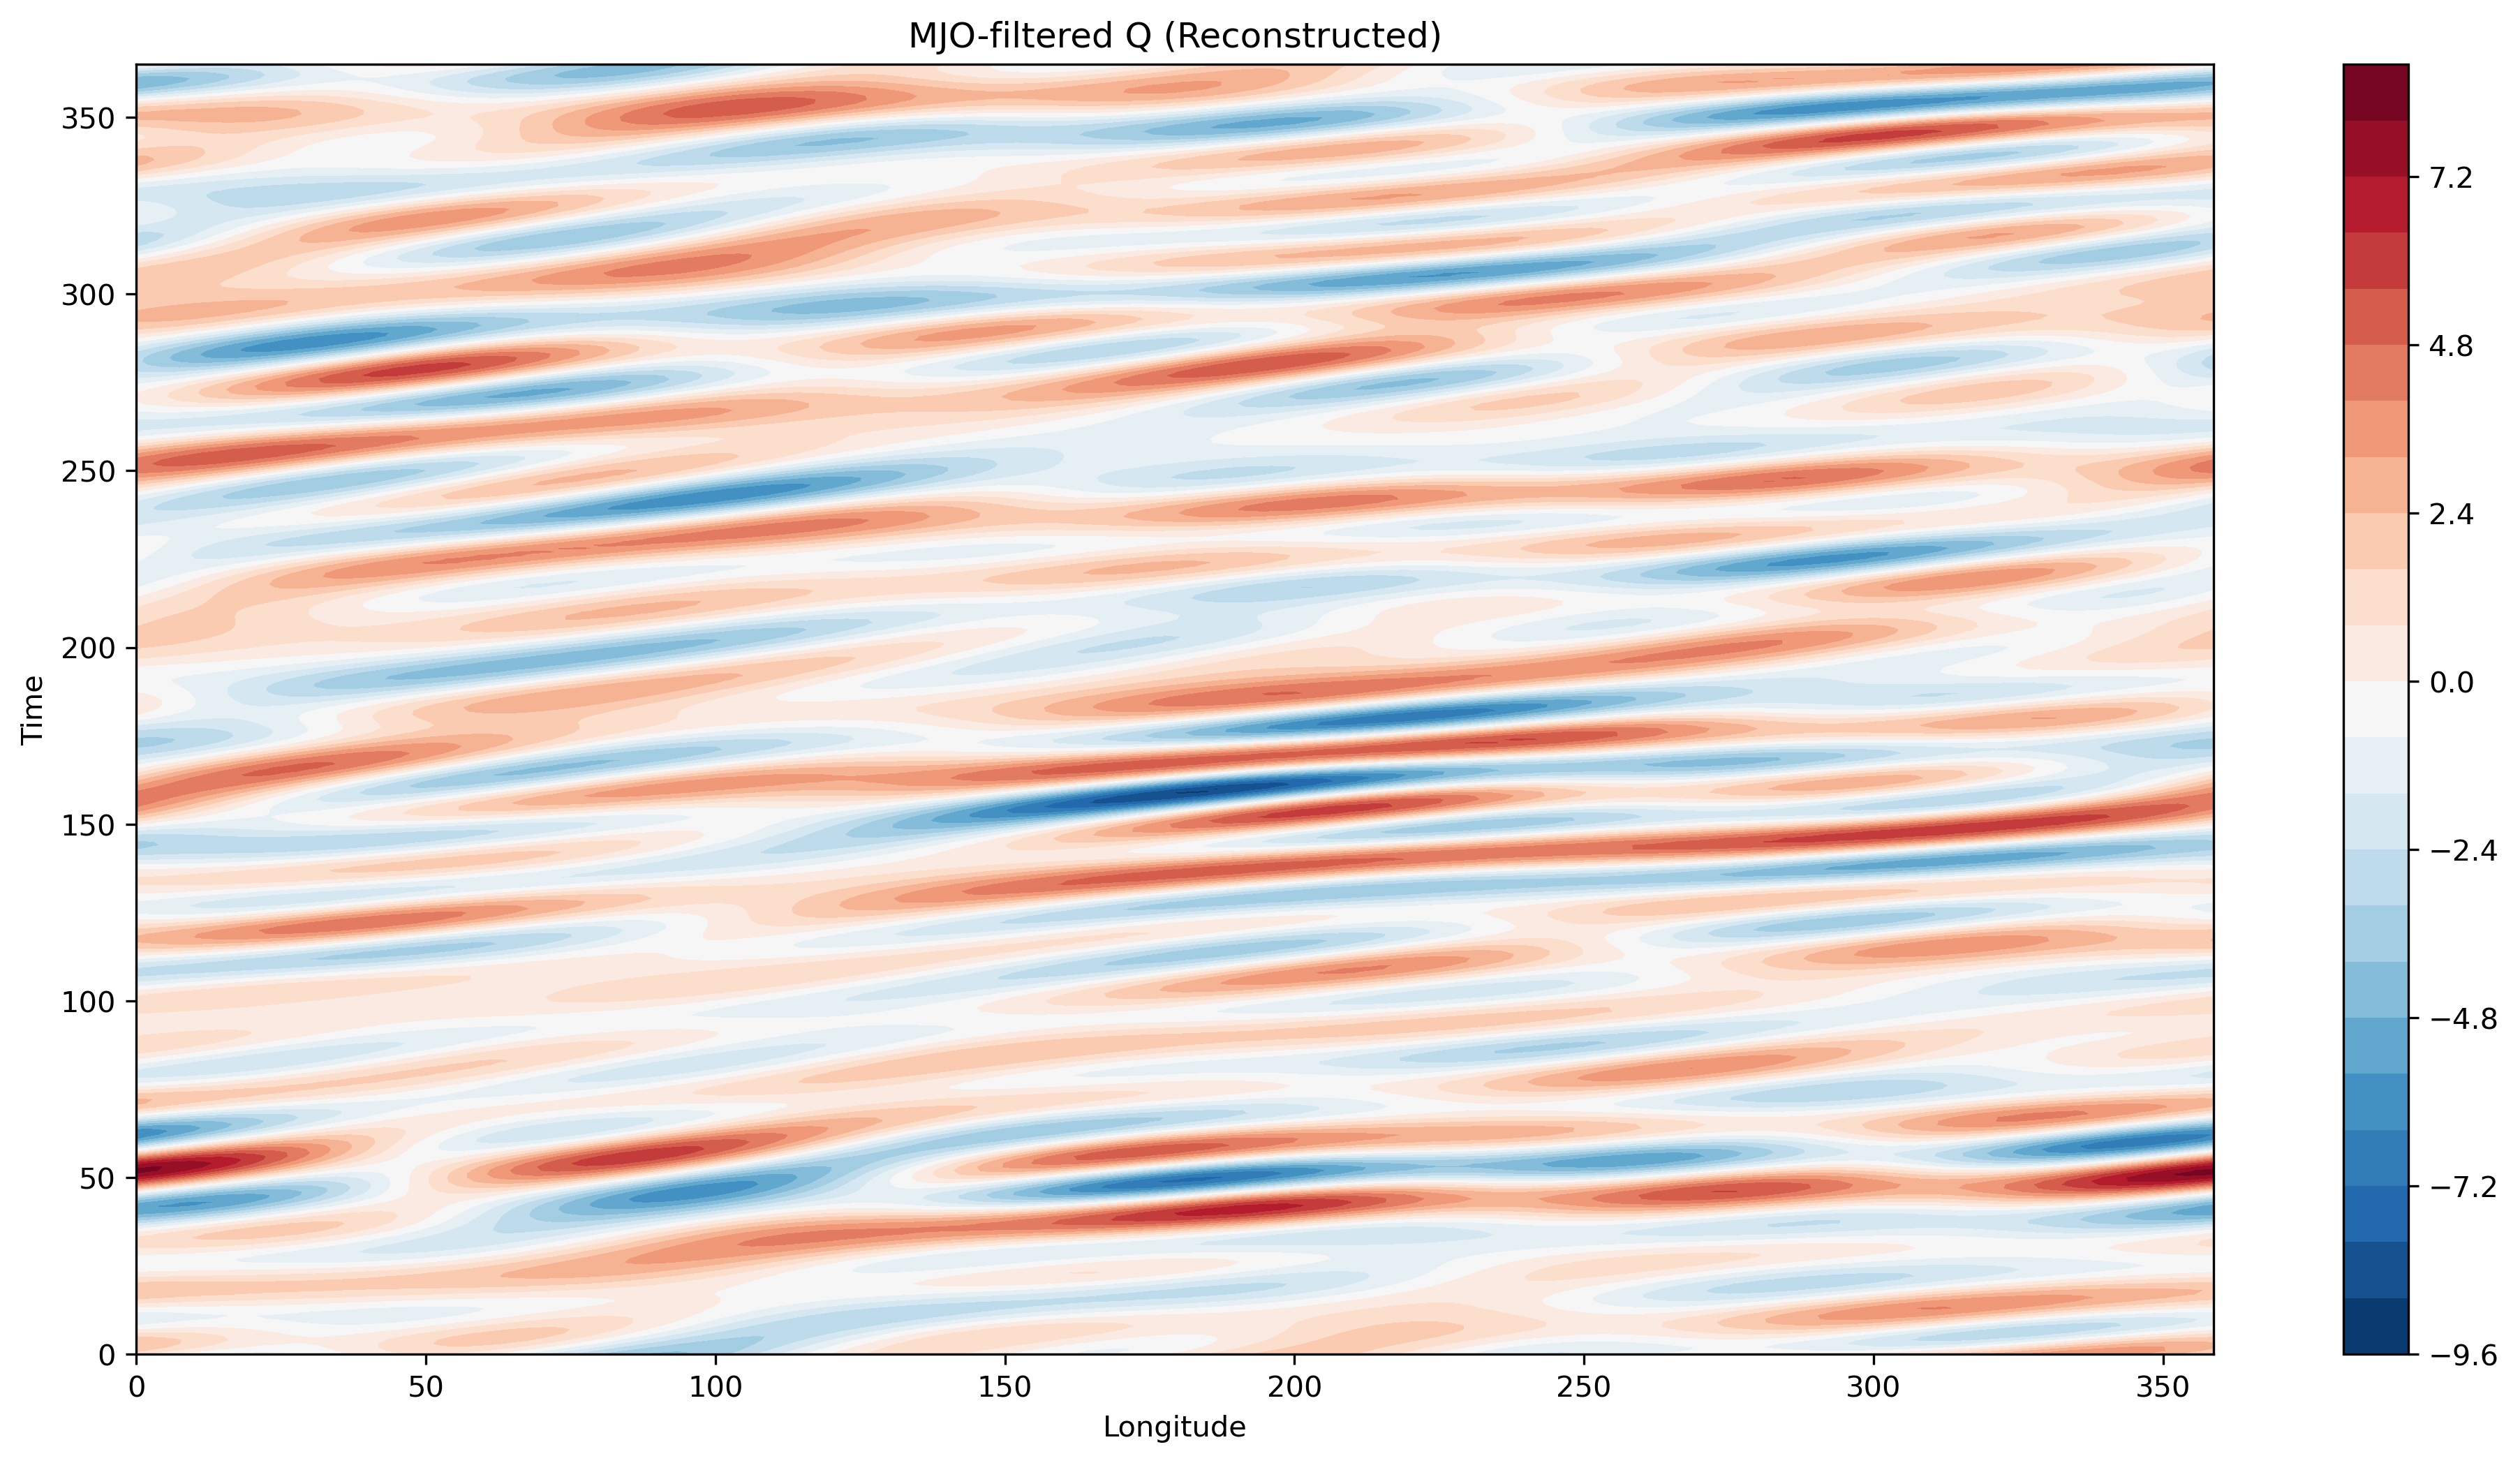

In [21]:
# 初始化
mjo_filter = MJOFilter(wavenumber_range=(1, 5), period_range=(14, 60))

# 濾波並取得 q_recon
q_mjo = mjo_filter.fit_transform(Q, lat, lon, lat_range=(-15, 15))

# 自己畫 Hovmöller（你用自己的方式）
plt.figure(figsize=(16,8), dpi=300.)
plt.contourf(lon, np.arange(q_mjo.shape[0]), q_mjo, levels=21, cmap="RdBu_r")
plt.title("MJO-filtered Q (Reconstructed)")
plt.xlabel("Longitude")
plt.ylabel("Time")
# plt.ylim([0,40])
plt.colorbar()


In [25]:
def lag_composite_signal(q_mjo, PC, lags=np.arange(-20, 21), threshold=1.0):
    """
    Construct lag-longitude composite based on PC amplitude threshold.

    Parameters:
    - q_mjo: (time, lon) MJO-filtered field
    - PC: (time,) reference index (e.g., PC1 from EOF)
    - lags: array of lags to include (e.g., -20 to 20)
    - threshold: only include times where |PC| > threshold

    Returns:
    - comp: (len(lags), lon), lag-lon composite
    """
    nt, nlon = q_mjo.shape
    comp_stack = []

    for t_ref in range(nt):
        if np.abs(PC[t_ref]) < threshold:
            continue
        t_lag = t_ref + lags
        if np.any((t_lag < 0) | (t_lag >= nt)):
            continue
        segment = q_mjo[t_lag, :]  # shape (lag, lon)
        comp_stack.append(segment)

    if len(comp_stack) == 0:
        raise ValueError("No valid events found with given threshold.")

    comp = np.mean(np.stack(comp_stack, axis=0), axis=0)
    return comp


In [28]:
# RMM plot
def plot_mjo_phase_space(figsize):
    
    import numpy as np
    from matplotlib import pyplot as plt
    import matplotlib.lines as lines
    
    fig, ax = plt.subplots(1,1,figsize=figsize) 
    
    ax.set_xlim(-4,4)
    ax.set_ylim(-4,4)
    ax.set_xticks(range(-4,5))
    ax.set_yticks(range(-4,5))

    # plot mjo phase diagram lines
    line1 = lines.Line2D([np.cos(np.pi/4), 4], [np.sin(np.pi/4), 4], color='black', linestyle='--', lw=1)
    ax.add_line(line1)
        
    line2 = lines.Line2D([np.cos(3*np.pi/4), -4], [np.sin(np.pi/4), 4], color='black', linestyle='--', lw=1)
    ax.add_line(line2)
        
    line3 = lines.Line2D([np.cos(np.pi/4), 4], [np.sin(7*np.pi/4), -4], color='black', linestyle='--', lw=1)
    ax.add_line(line3)
        
    line4 = lines.Line2D([np.cos(3*np.pi/4), -4], [np.sin(7*np.pi/4), -4], color='black', linestyle='--', lw=1)
    ax.add_line(line4)
        
    line5 = lines.Line2D([-4, -1], [0, 0], color='black', linestyle='--', lw=1)
    ax.add_line(line5)
        
    line6 = lines.Line2D([1, 4], [0, 0], color='black', linestyle='--', lw=1)
    ax.add_line(line6)
        
    line7 = lines.Line2D([0, 0], [1, 4], color='black', linestyle='--', lw=1)
    ax.add_line(line7)
        
    line8 = lines.Line2D([0, 0], [-1, -4], color='black', linestyle='--', lw=1)
    ax.add_line(line8)
        
    amp1_circ = plt.Circle((0, 0), 1, color='black', fill=False)
    ax.add_patch(amp1_circ)
        
    # add phase diagram texts
    ax.text( 1,3,'Phase 6', size='x-large', weight='semibold')
    ax.text(-2,3,'Phase 7', size='x-large', weight='semibold')
    ax.text(2.8,1  ,'Phase 5', size='x-large', weight='semibold', ha='center')
    ax.text(-2.8,1  ,'Phase 8', size='x-large', weight='semibold', ha='center')
        
    ax.text( 1,-3,'Phase 3', size='x-large', weight='semibold')
    ax.text(-2,-3,'Phase 2', size='x-large', weight='semibold')
    ax.text(2.8,-1  ,'Phase 4', size='x-large', weight='semibold', ha='center')
    ax.text(-2.8,-1  ,'Phase 1', size='x-large', weight='semibold', ha='center')
        
    ax.text( 0,3.7,'Pacific Ocean', ha='center', bbox=dict(facecolor='white', edgecolor='white'))
    ax.text( 0,-3.8,'Indian Ocean', ha='center', bbox=dict(facecolor='white', edgecolor='white'))
    ax.text(-3.8,0,'West. Hem., Africa', va='center', rotation='vertical', bbox=dict(facecolor='white', edgecolor='white'))
    ax.text(3.7,0,'Maritime Continent', va='center', rotation='vertical', bbox=dict(facecolor='white', edgecolor='white'))
        
    ax.set_xlabel('RMM1')
    ax.set_ylabel('RMM2')

    return fig, ax

Selected latitude indices: [ 80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97
  98  99 100 101 102 103 104 105 106 107 108 109 110 111]
Shape after latitude selection (u850): (366, 32, 288)
Integrated Q shape: (366, 32, 288)
Shape after latitude-weighted averaging (u850): (366, 288)
Filtered shape (u850): (366, 288)
Combined shape after preprocessing: (366, 864)
n_component: 366


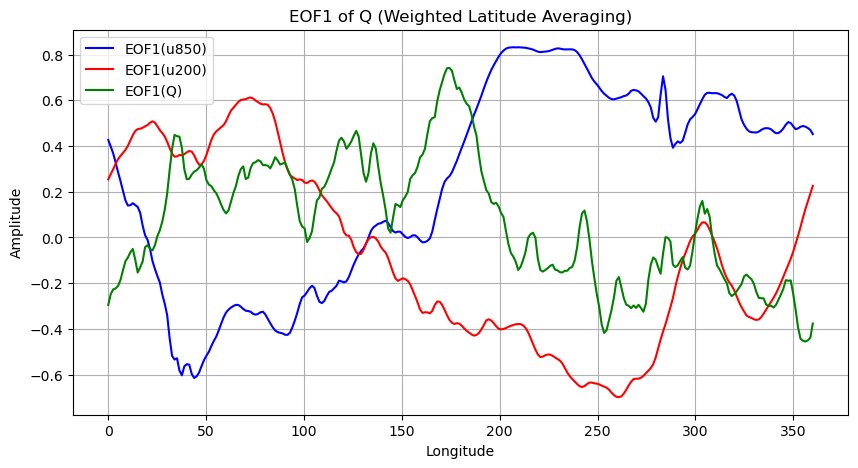

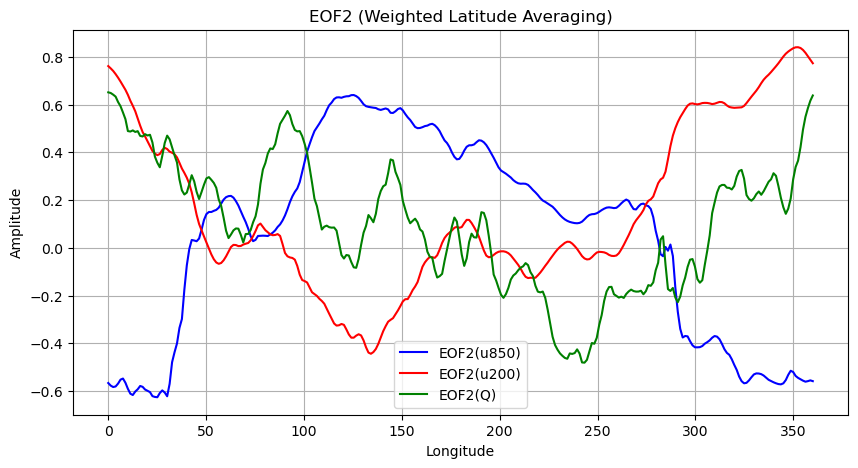

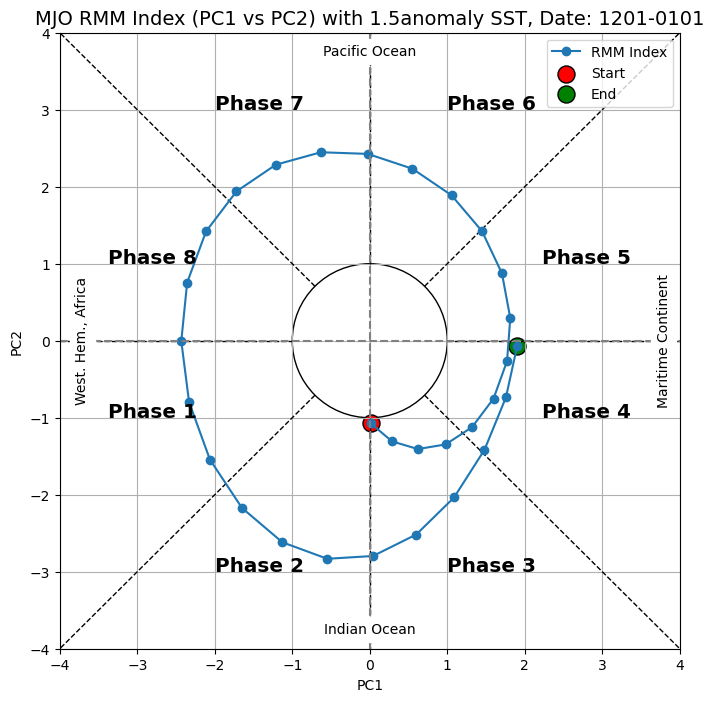

In [29]:
from EOF import EOF
# Step 1: Load Data
# with Dataset("f09.F2000_MJO_1.5anomaly.cam.h0.1101_0201.nc", "r") as f:
with Dataset("f09.F2000_MJO_1year.cam.h0.1year.nc", "r") as f:
    
    # print(f.variables.keys())
    u850 = f["U850"][:]
    v850 = f["V850"][:]
    precl = f["PRECL"][:]
    u200 = f["U200"][:]
    Q = f["FLNT"][:] 
    lat = f["lat"][:]
    time = f["time"][:]

# Step 2: Select latitude range (-15 to 15)
lat_mask = (lat >= -15) & (lat <= 15)
print("Selected latitude indices:", np.where(lat_mask)[0])

# Subset the data for the selected latitudes
u850 = u850[:, lat_mask, :]
v850 = v850[:, lat_mask, :]
precl = precl[:, lat_mask, :]
u200 = u200[:, lat_mask, :]
Q = Q[:, lat_mask, :]
print("Shape after latitude selection (u850):", u850.shape)


# Step 3: Column integrated Q (mean over levels)
# q_int = np.mean(Q, axis=1)  # Direct mean over vertical levels
q_int = Q
print("Integrated Q shape:", q_int.shape)

# Step 4: Latitude averaging with weighting
def latitude_weighted_average(data, lat):
    """
    Perform latitude-weighted averaging to obtain zonal mean.
    """
    # Calculate the weights
    weights = np.sqrt(np.cos(np.deg2rad(lat)))
    weights /= weights.sum()  # Normalize weights

    # Apply the weights to the data (broadcasting the weights along latitude)
    weighted_data = data * weights[:, np.newaxis]
    # Sum over latitude with weights applied
    return np.sum(weighted_data, axis=1)


# Apply latitude-weighted averaging to each variable
u850 = latitude_weighted_average(u850, lat[lat_mask])
v850 = latitude_weighted_average(v850, lat[lat_mask])
precl = latitude_weighted_average(precl, lat[lat_mask])
u200 = latitude_weighted_average(u200, lat[lat_mask])
q_int = latitude_weighted_average(q_int, lat[lat_mask])
print("Shape after latitude-weighted averaging (u850):", u850.shape)

# Step 5: Remove seasonal cycle with bandpass
from scipy.signal import filtfilt, butter

def band_pass_filter(data, lowcut=1/60, highcut=1/14, fs=1):
    """
    Band-pass filter to isolate MJO signals (14~60 days).
    """
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(2, [low, high], btype='band')
    return filtfilt(b, a, data, axis=0)

# Apply band-pass filter to isolate MJO signal
u850 = band_pass_filter(u850, lowcut=1/60, highcut=1/14)
u200 = band_pass_filter(u200, lowcut=1/60, highcut=1/14)
q_int = band_pass_filter(q_int, lowcut=1/60, highcut=1/14)
v850 = band_pass_filter(v850, lowcut=1/60, highcut=1/14)
precl = band_pass_filter(precl, lowcut=1/60, highcut=1/14)

print("Filtered shape (u850):", u850.shape)

# Step 6: Preprocess Data (remove overall mean and normalize)
def preprocess(data):
    data_anom = data - np.mean(data, axis=0) # anamoly to time
    data_std = np.std(data_anom, axis=0)
    # data_std[data_std == 0] = 1
    data_norm = data_anom / data_std
    return data_norm

# Preprocess each variable
u850_norm = preprocess(u850)
v850_norm = preprocess(v850)
u200_norm = preprocess(u200)
q_int_norm = preprocess(q_int)


# Step 7: Flatten and combine variables
time_dim, lon_dim = u850.shape
u850_flat = u850_norm.reshape(time_dim, lon_dim)
v850_flat = v850_norm.reshape(time_dim, lon_dim)

u200_flat = u200_norm.reshape(time_dim, lon_dim)
q_int_flat = q_int_norm.reshape(time_dim, lon_dim)

# combined = np.hstack((u850_flat, u200_flat, q_int_flat))
### FIXED! should use concatenate not hstack
# Concatenate in the correct order (variables are grouped, not mixed)
combined = np.concatenate((u850_flat, u200_flat, q_int_flat), axis=1) # (time, lon)
print("Combined shape after preprocessing:", combined.shape)

# Step 8: Calculate EOF and PC with latitude weighting
def Cal_EOF_PC(input_data):
    """
    Calculate EOF and PC from input data.
    """
    # Initialize an EOF instance
    n_component = min(input_data.shape[0], input_data.size // input_data.shape[0])
    print("n_component:", n_component)
    eof_instance = EOF((input_data,), n_components=n_component, field="1D")
    eof_instance.get()

    # Extract EOFs and PCs
    EOF1, EOF2, EOF3 = eof_instance.EOF[:3]
    PC1, PC2, PC3 = eof_instance.PC[:3]

    # Normalize PCs
    PC1_norm = (PC1 - PC1.mean()) / PC1.std()
    PC2_norm = (PC2 - PC2.mean()) / PC2.std()
    PC3_norm = (PC3 - PC3.mean()) / PC3.std()
    

    # EOFs with units 
    EOF1_norm = EOF1 * PC1.std() # (EOF1 - EOF1.mean()) / EOF1.std()
    EOF2_norm = EOF2 * PC2.std() # (EOF2 - EOF2.mean()) / EOF2.std()
    EOF3_norm = EOF3 * PC3.std() # (EOF2 - EOF2.mean()) / EOF2.std()
    
    return PC1_norm, PC2_norm, PC3_norm, EOF1_norm, EOF2_norm, EOF3_norm, eof_instance.explained[:10]


PC1, PC2, PC3, EOF1, EOF2, EOF3, explain = Cal_EOF_PC(combined)

# Step 9: Plot EOF1s
plt.figure(figsize=(10, 5))
plt.plot(np.linspace(0,360,288),EOF1[:288], label='EOF1(u850)', color='blue')
plt.plot(np.linspace(0,360,288),EOF1[288:288*2], label='EOF1(u200)', color='Red')
plt.plot(np.linspace(0,360,288),EOF1[288*2:288*3], label='EOF1(Q)', color='Green')


plt.title('EOF1 of Q (Weighted Latitude Averaging)')
plt.xlabel('Longitude')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()
plt.show()

# Step 9: Plot EOF1 of Q
plt.figure(figsize=(10, 5))
plt.plot(np.linspace(0,360,288),EOF2[:288], label='EOF2(u850)', color='blue')
plt.plot(np.linspace(0,360,288),EOF2[288:288*2], label='EOF2(u200)', color='Red')
plt.plot(np.linspace(0,360,288),EOF2[288*2:288*3], label='EOF2(Q)', color='Green')


plt.title('EOF2 (Weighted Latitude Averaging)')
plt.xlabel('Longitude')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()
plt.show()


# Step 10: Plot RMM Index (PC1 vs PC2)
# 用固定半徑與角度生成一圈
theta = np.linspace(0, 2 * np.pi, 30)
radius = 0.85  # 固定 amplitude，可自由調整

PC1_demo = radius * np.cos(theta)  # RMM1
PC2_demo = radius * np.sin(theta)  # RMM2


start = 30
end   = 60
fig, ax = plot_mjo_phase_space(figsize=(8,8))
ax.plot(PC1[start:end], -PC2[start:end], marker='o', linestyle='-', label='RMM Index')
# ax.plot(PC1_demo[17:], PC2_demo[17:], marker='o', linestyle='-', color="Blue", label='RMM Index')
# ax.plot(PC1_demo[:13], PC2_demo[:13], marker='o', linestyle='-', color="Blue")
# ax.scatter(PC1_demo[17], PC2_demo[17], color='red', edgecolors='black', s=150, label='Start')
# ax.scatter(PC1_demo[int(13-1)], PC2_demo[int(13-1)], color='green', edgecolors='black', s=150, label='End')



ax.scatter(PC1[start], -PC2[start], color='red', edgecolors='black', s=150, label='Start')
ax.scatter(PC1[int(end-1)], -PC2[int(end-1)], color='green', edgecolors='black', s=150, label='End')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('MJO RMM Index (PC1 vs PC2) with 1.5anomaly SST, Date: 1201-0101', fontsize=14)
ax.axhline(0, color='gray', linestyle='--')
ax.axvline(0, color='gray', linestyle='--')
ax.grid(True)
ax.legend()
plt.show()

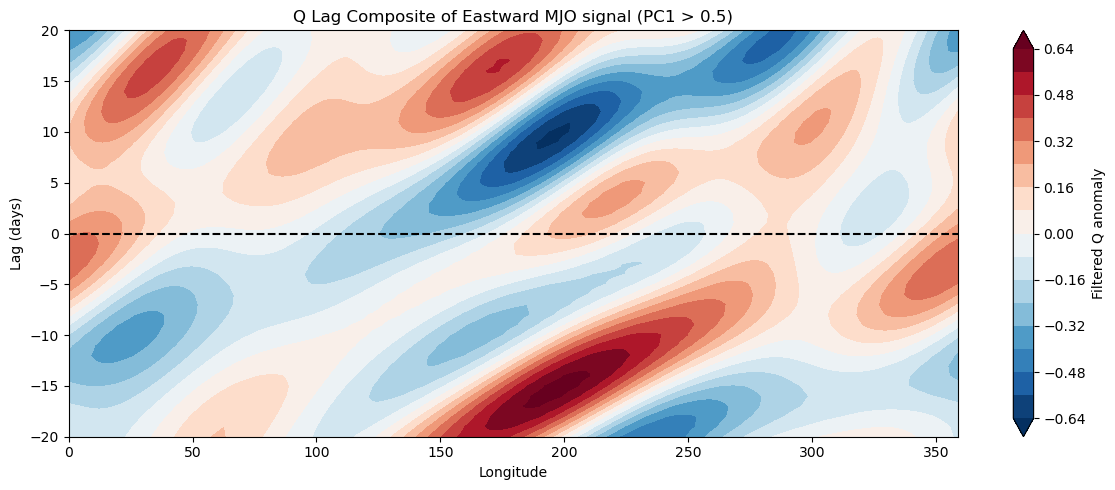

In [30]:
# composite
comp = lag_composite_signal(q_mjo, PC1, lags=np.arange(-20, 21), threshold=0.5)

# 畫圖
plt.figure(figsize=(12, 5))
cf = plt.contourf(lon, np.arange(-20, 21), comp, levels=21, cmap='RdBu_r', extend='both')
plt.axhline(0, color='k', linestyle='--')
plt.xlabel("Longitude")
plt.ylabel("Lag (days)")
plt.title("Q Lag Composite of Eastward MJO signal (PC1 > 0.5)")
plt.colorbar(cf, label="Filtered Q anomaly")
plt.tight_layout()
plt.show()
